# Imports

In [2]:
%%time

import numpy
import folium
import pandas
from mpl_toolkits.mplot3d import Axes3D
import seaborn
import matplotlib.pyplot as plt
import folium

%matplotlib inline
%pylab inline

seaborn.set_style('whitegrid')


Populating the interactive namespace from numpy and matplotlib
CPU times: user 2.53 s, sys: 244 ms, total: 2.78 s
Wall time: 8.27 s


# Homicide reports 1980-2014
## Reading & filtering data
### First attempt to read data

In [3]:
homicide = pandas.read_csv("./datasets/homocide_reports_1980-2014.csv.gz") \
                            .drop(['Record ID', 'Agency Code'], axis=1)
homicide

/home/boxy/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,Crime Solved,Victim Sex,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,Yes,Male,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,Yes,Male,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,No,Female,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,Yes,Male,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,No,Female,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


### Perpetrator age contains int try and convert to int

In [4]:
len(homicide.index)
#homicide[homicide['State'] != 'Alaska'].head()

638454

In [5]:
try:
    homicide = pandas.read_csv("./datasets/homocide_reports_1980-2014.csv.gz", dtype={"Perpetrator Age": int}) \
                                .drop(['Record ID', 'Agency Code'], axis=1)
except ValueError as e:
    print(str(type(e).__name__) + ": " + str(e.args))

ValueError: invalid literal for int() with base 10: ' '

### Check dirty data field

In [ ]:
homicide = pandas.read_csv("./datasets/homocide_reports_1980-2014.csv.gz", dtype={"Perpetrator Age": object}) \
                            .drop(['Record ID', 'Agency Code'], axis=1)
homicide[homicide['Perpetrator Age'] == ' ']

### Filter and generalize data and save to a csv for future use

In [7]:
%%time

homicide = pandas.read_csv("./datasets/homocide_reports_1980-2014.csv.gz", dtype={"Perpetrator Age": object}) \
                            .drop(['Record ID', 'Agency Code'], axis=1)
# Perpetrator Age contains dirty data

homicide['Perpetrator Age'] = homicide['Perpetrator Age'].replace(' ', 0).apply(pandas.to_numeric)

homicide.loc[(homicide['Relationship'] == 'Wife') | (homicide['Relationship'] == 'Ex-Wife') |
             (homicide['Relationship'] == 'Girlfriend') |
             (homicide['Relationship'] == 'Common-Law Wife'), 'Relation category'] = 'Partner-F'

homicide.loc[(homicide['Relationship'] == 'Husband') | (homicide['Relationship'] == 'Ex-Husband') |
             (homicide['Relationship'] == 'Boyfriend') |
             (homicide['Relationship'] == 'Common-Law Husband'), 'Relation category'] = 'Partner-M'

homicide.loc[(homicide['Relationship'] == 'Father') | (homicide['Relationship'] == 'In-Law') |
             (homicide['Relationship'] == 'Mother') | (homicide['Relationship'] == 'Stepfather') |
             (homicide['Relationship'] == 'Stepmother'), 'Relation category'] = 'Parent'

homicide.loc[(homicide['Relationship'] == 'Daughter') | (homicide['Relationship'] == 'Son') |
             (homicide['Relationship'] == 'Stepdaughter') |
             (homicide['Relationship'] == 'Stepson'), 'Relation category'] = 'Children'

homicide.loc[(homicide['Relationship'] == 'Brother') | (homicide['Relationship'] == 'Sister'),
             'Relation category'] = 'Sibling'

homicide.loc[(homicide['Relationship'] == 'Employee') | (homicide['Relationship'] == 'Employer'),
             'Relation category'] = 'Work'

homicide.loc[(homicide['Relationship'] == 'Boyfriend/Girlfriend') & (homicide['Victim Sex'] == 'Female'),
             'Relation category'] = 'Partner-F'

homicide.loc[(homicide['Relationship'] == 'Boyfriend/Girlfriend') & ((homicide['Victim Sex'] == 'Male') |
            (homicide['Victim Sex'] == 'Unknown')), 'Relation category'] = 'Partner-M'

homicide.to_csv('./datasets/homocide_reports_1980-2014_filtered.csv.gz', compression='gzip')

CPU times: user 1min 4s, sys: 252 ms, total: 1min 4s
Wall time: 1min 23s


### Load pre-filtered csv

In [8]:
%time homicide = pandas.read_csv("./datasets/homocide_reports_1980-2014_filtered.csv.gz")

CPU times: user 3.06 s, sys: 56 ms, total: 3.12 s
Wall time: 3.63 s


### Check if we have null fields in our columns

In [9]:
%time homicide.isnull().any()

CPU times: user 968 ms, sys: 4 ms, total: 972 ms
Wall time: 1.25 s


Unnamed: 0               False
Agency Name              False
Agency Type              False
City                     False
State                    False
Year                     False
Month                    False
Incident                 False
Crime Type               False
Crime Solved             False
Victim Sex               False
Victim Age               False
Victim Race              False
Victim Ethnicity         False
Perpetrator Sex          False
Perpetrator Age          False
Perpetrator Race         False
Perpetrator Ethnicity    False
Relationship             False
Weapon                   False
Victim Count             False
Perpetrator Count        False
Record Source            False
Rel_Category              True
dtype: bool

### Check types per comumn

In [10]:
%time homicide.dtypes

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 339 µs


Unnamed: 0                int64
Agency Name              object
Agency Type              object
City                     object
State                    object
Year                      int64
Month                    object
Incident                  int64
Crime Type               object
Crime Solved             object
Victim Sex               object
Victim Age                int64
Victim Race              object
Victim Ethnicity         object
Perpetrator Sex          object
Perpetrator Age           int64
Perpetrator Race         object
Perpetrator Ethnicity    object
Relationship             object
Weapon                   object
Victim Count              int64
Perpetrator Count         int64
Record Source            object
Rel_Category             object
dtype: object

### Print description of our data set

In [11]:
%time homicide.describe()

CPU times: user 300 ms, sys: 0 ns, total: 300 ms
Wall time: 694 ms


,Unnamed: 0,Year,Incident,Victim Age,Perpetrator Age,Victim Count,Perpetrator Count
count,638454.00000,638454.000000,638454.000000,638454.000000,638454.000000,638454.000000,638454.000000
mean,319226.50000,1995.801102,22.967924,35.033512,20.322665,0.123334,0.185224
std,184305.93872,9.927693,92.149821,41.628306,17.886846,0.537733,0.585496
min,0.00000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,159613.25000,1987.000000,1.000000,22.000000,0.000000,0.000000,0.000000
50%,319226.50000,1995.000000,2.000000,30.000000,21.000000,0.000000,0.000000
75%,478839.75000,2004.000000,10.000000,42.000000,31.000000,0.000000,0.000000
max,638453.00000,2014.000000,999.000000,998.000000,99.000000,10.000000,10.000000


### Show pepetrator sex and victim sex

In [12]:
%time pandas.crosstab(homicide['Victim Sex'], homicide['Perpetrator Sex'])

CPU times: user 172 ms, sys: 0 ns, total: 172 ms
Wall time: 356 ms


Perpetrator Sex,Female,Male,Unknown
Victim Sex,,,
Female,10869,99381,33095
Male,37629,299879,156617
Unknown,50,281,653


### Show weapon use by sex

CPU times: user 496 ms, sys: 8 ms, total: 504 ms
Wall time: 1.36 s


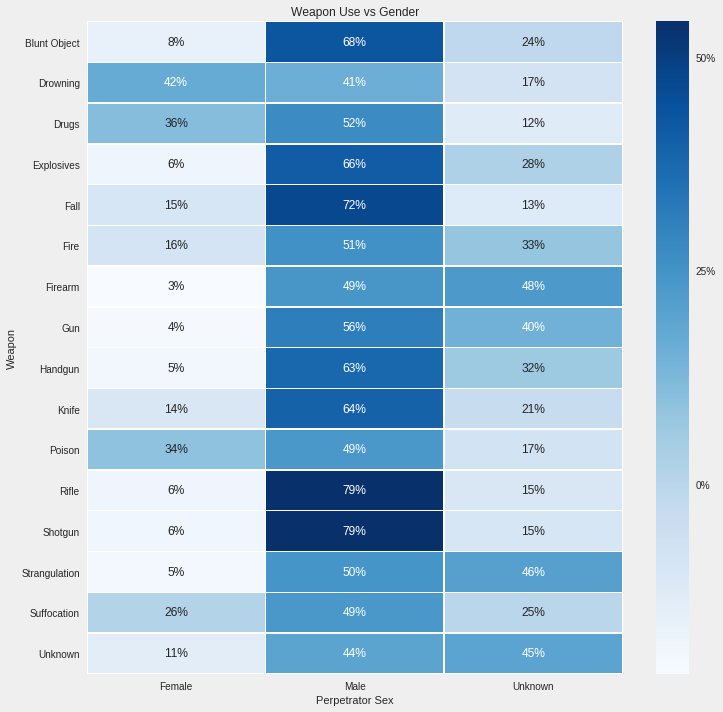

In [13]:
%%time

pyplot.figure(figsize=(12, 12), facecolor='#efefef')
seaborn.set()
ax = seaborn.heatmap(pandas.crosstab(homicide.Weapon, homicide['Perpetrator Sex'])
                     .apply(lambda r: r / r.sum(), axis=1), annot=True, fmt=".0%", linewidths=.5, cmap='Blues')
ax.set_title('Weapon Use vs Gender')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .50, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.plot()


### Show weapon use by sex with unkown filtered out.

CPU times: user 576 ms, sys: 4 ms, total: 580 ms
Wall time: 1.06 s


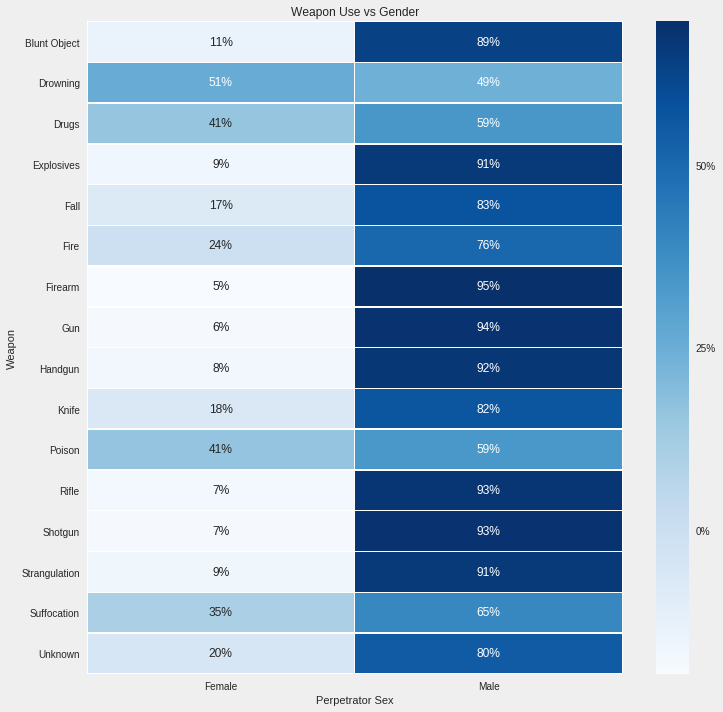

In [41]:
%%time

pyplot.figure(figsize=(12, 12), facecolor='#efefef')
seaborn.set()
# ax.set_ticklabels(['0%', '20%', '75%', '100%'])
unknown_filter = homicide[homicide['Perpetrator Sex'] != 'Unknown']
ax = seaborn.heatmap(pandas.crosstab(unknown_filter.Weapon, unknown_filter['Perpetrator Sex'])
                     .apply(lambda r: r / r.sum(), axis=1), annot=True, fmt=".0%", linewidths=.5, cmap='Blues')
ax.set_title('Weapon Use vs Gender')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .50, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.plot()


In [103]:
%%time

Male_Filter = unknown_filter.loc[unknown_filter['Perpetrator Sex'] == "Male"]
Female_Filter = unknown_filter.loc[unknown_filter['Perpetrator Sex'] == "Female"]

Male_Filter['Weapon'].unique()

SyntaxError: invalid syntax (<unknown>, line 5)

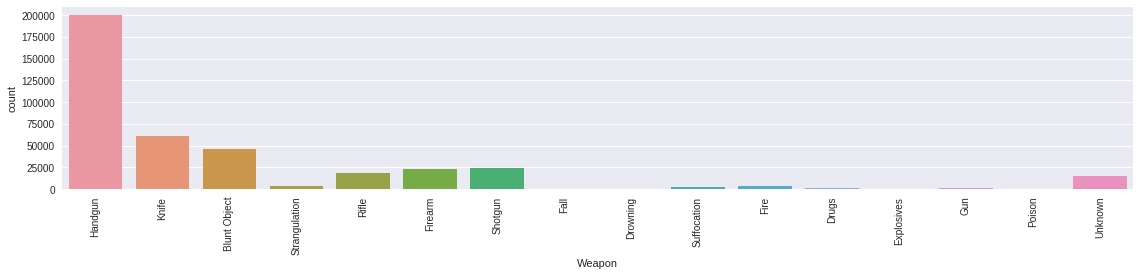

In [125]:
s = seaborn.factorplot(x='Weapon', data=Male_Filter,kind="count", aspect=4,
                      order=['Handgun','Knife','Blunt Object', 'Strangulation', 'Rifle', 'Firearm',
                       'Shotgun', 'Fall',  'Drowning', 'Suffocation', 
                       'Fire', 'Drugs', 'Explosives', 'Gun', 'Poison','Unknown' ])
s.set_xticklabels(rotation=90)
seaborn.plt.tight_layout()


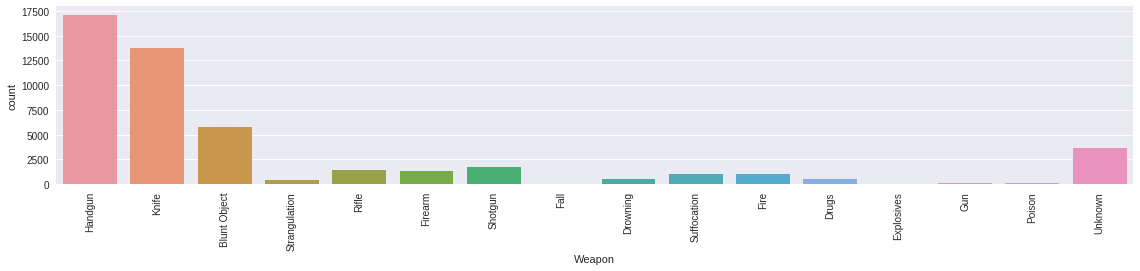

In [124]:
s = seaborn.factorplot(x='Weapon', data=Female_Filter,kind="count", aspect=4,
                       order=['Handgun','Knife','Blunt Object', 'Strangulation', 'Rifle', 'Firearm',
                       'Shotgun', 'Fall',  'Drowning', 'Suffocation',
                       'Fire', 'Drugs', 'Explosives', 'Gun', 'Poison','Unknown', ])
s.set_xticklabels(rotation=90)
seaborn.plt.tight_layout()

### Amount of homicides per month

AttributeError: Unknown property kind

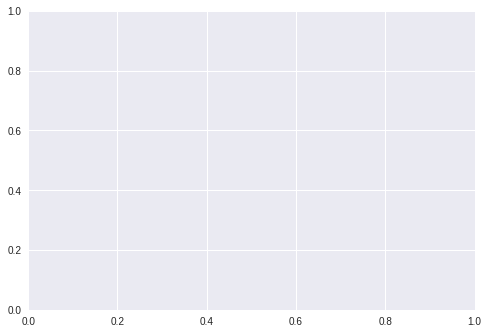

In [78]:
%%time

s = seaborn.countplot(x='Month', data=homicide, palette="husl")
seaborn.plt.tight_layout()


### Show perpetrator age with unkown ages filtered out

CPU times: user 1.28 s, sys: 68 ms, total: 1.34 s
Wall time: 2.8 s


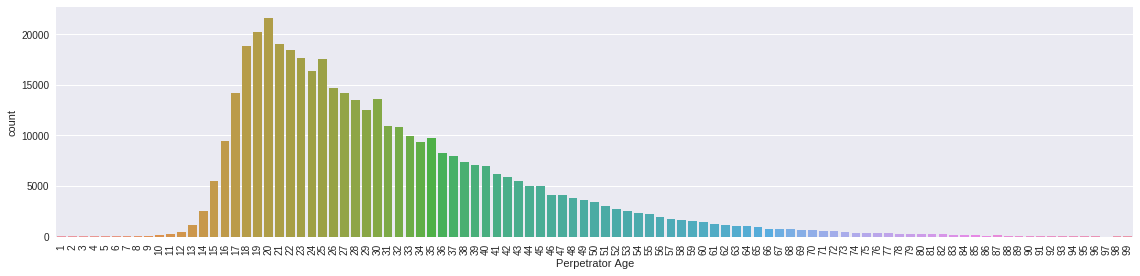

In [17]:
%%time

s = seaborn.factorplot(x='Perpetrator Age', data=homicide[homicide['Perpetrator Age'] != 0],
                        kind="count", aspect=4)
s.set_xticklabels(rotation=90)
seaborn.plt.tight_layout()


### Show homcide count by race

CPU times: user 1.28 s, sys: 0 ns, total: 1.28 s
Wall time: 1.49 s


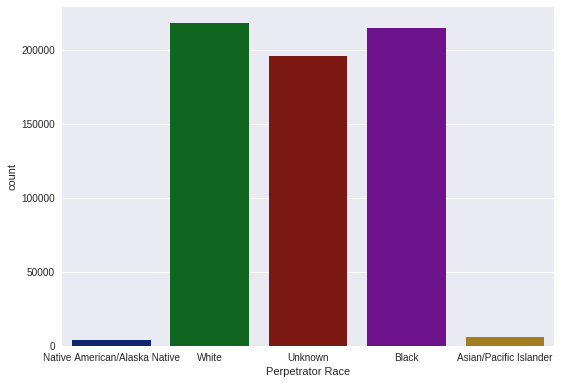

In [18]:
%%time

seaborn.countplot(x='Perpetrator Race', data=homicide, palette="dark")
seaborn.plt.tight_layout()


### Pepetrator gender vs weapon used

CPU times: user 456 ms, sys: 4 ms, total: 460 ms
Wall time: 713 ms


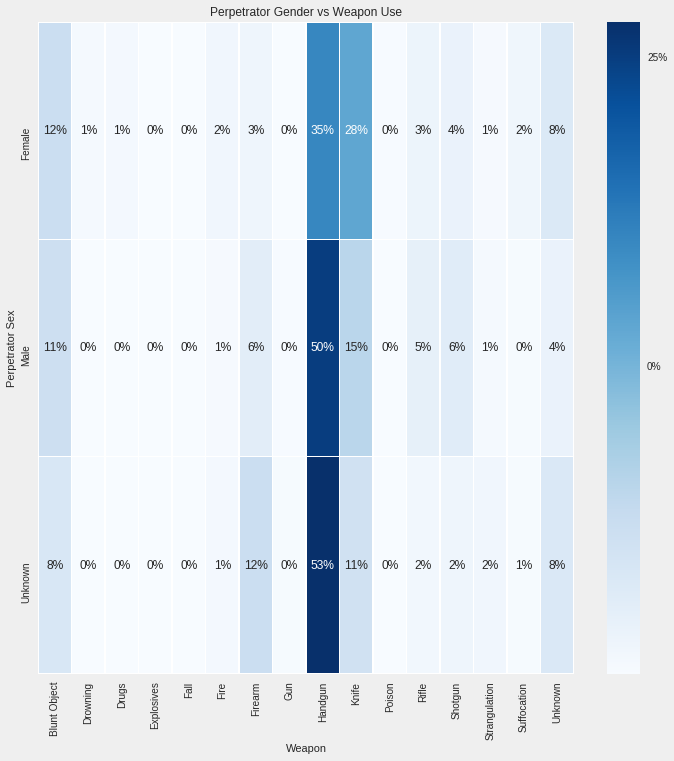

In [19]:
%%time

plt.figure(figsize=(12, 12), facecolor='#efefef')
seaborn.set()
# ax.set_ticklabels(['0%', '25%', '75%', '100%'])
ax = seaborn.heatmap(pandas.crosstab(homicide['Perpetrator Sex'], homicide.Weapon).apply(lambda r: r / r.sum(), axis=1),
                     annot=True, fmt=".0%", linewidths=.5, cmap='Blues')
ax.set_title('Perpetrator Gender vs Weapon Use')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .50, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])


### Count of homcides per state

CPU times: user 1.43 s, sys: 4 ms, total: 1.44 s
Wall time: 2.18 s


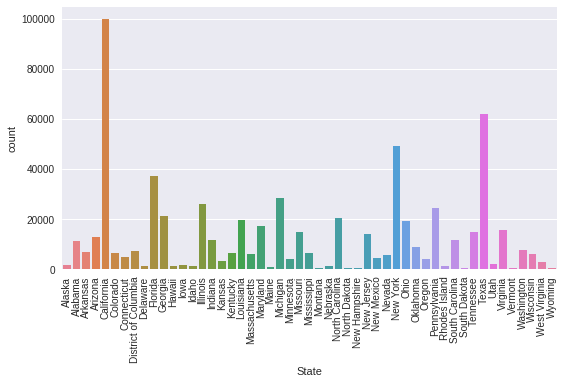

In [20]:
%%time

seaborn.countplot(x='State', data=homicide, palette="husl")

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

seaborn.plt.tight_layout()


# Sex offenders
## Read data set

In [21]:
%%time

sexoff = pandas.read_csv("./datasets/Sex_Offenders.csv", dtype={"AGE": int})

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 55.8 ms


## Show data

In [22]:
%time sexoff

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.87 ms


,LAST,FIRST,BLOCK,GENDER,RACE,BIRTH DATE,AGE,HEIGHT,WEIGHT,VICTIM MINOR
0,NIEVES,EDUARDO,033XX W CRYSTAL ST,MALE,WHITE HISPANIC,10/07/1968,48,600,200,Y
1,VALDEZ,JOSE,023XX W 23RD ST,MALE,WHITE HISPANIC,10/07/1976,40,602,235,N
2,CRAWFORD,ANDRE,11XXX S STATE ST,MALE,BLACK,10/07/1964,52,507,155,Y
3,MARTINEZ,SERGIO,054XX S ARCHER AVE,MALE,WHITE HISPANIC,10/07/1960,56,504,155,Y
4,CANCIO-HERNANDEZ,ERNESTO,015XX W GARFIELD BLVD,MALE,WHITE HISPANIC,10/08/1941,75,507,140,Y
5,URENDA,NOE,025XX W 46TH ST,MALE,WHITE HISPANIC,10/08/1973,43,506,164,Y
6,PAZ,JUAN,052XX S KILBOURN AVE,MALE,WHITE HISPANIC,10/09/1981,35,509,300,Y
7,MYLES,ROOSEVELT,002XX E 121ST ST,MALE,BLACK,10/09/1958,58,502,225,Y
8,WALTON,MARION,032XX N CICERO AVE,MALE,WHITE,10/09/1947,69,508,164,Y
9,DAVIS,DUANE,081XX S CAMPBELL AVE,MALE,BLACK,10/10/1961,55,511,180,Y


## Check if tables contain null

In [23]:
%time sexoff.isnull().any()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 6.27 ms


LAST            False
FIRST           False
BLOCK           False
GENDER          False
RACE            False
BIRTH DATE      False
AGE             False
HEIGHT          False
WEIGHT          False
VICTIM MINOR    False
dtype: bool

## Check data types

In [24]:
%time sexoff.dtypes

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 384 µs


LAST            object
FIRST           object
BLOCK           object
GENDER          object
RACE            object
BIRTH DATE      object
AGE              int64
HEIGHT           int64
WEIGHT           int64
VICTIM MINOR    object
dtype: object

## Show sex offenders by race

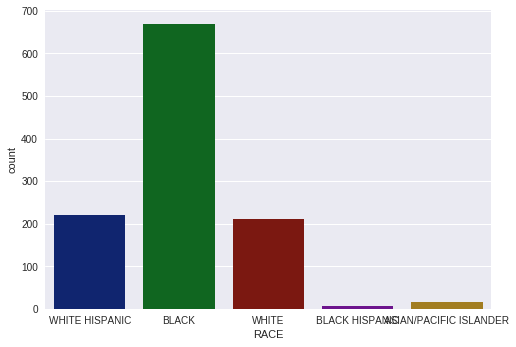

CPU times: user 336 ms, sys: 4 ms, total: 340 ms
Wall time: 735 ms


In [25]:
%%time

seaborn.countplot(x='RACE', data=sexoff, palette="dark")
seaborn.plt.show()


## Show amount of sex offenders by age when crime was commited

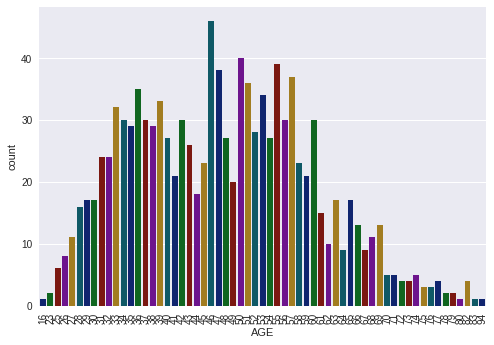

CPU times: user 1.05 s, sys: 12 ms, total: 1.06 s
Wall time: 1.61 s


In [26]:
%%time

seaborn.countplot(x='AGE', data=sexoff, palette="dark")

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

seaborn.plt.show()


## Show amount of sex offenders by gender

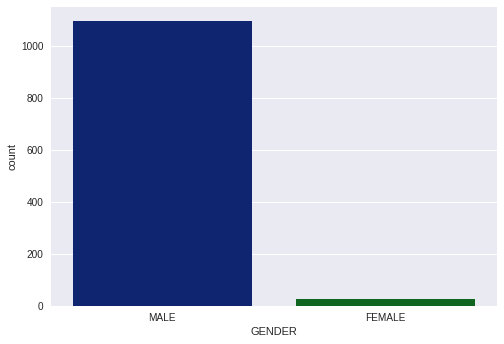

CPU times: user 268 ms, sys: 4 ms, total: 272 ms
Wall time: 614 ms


In [27]:
%%time

seaborn.countplot(x='GENDER', data=sexoff, palette="dark")
seaborn.plt.show()

## Show amount of sex offenders by height

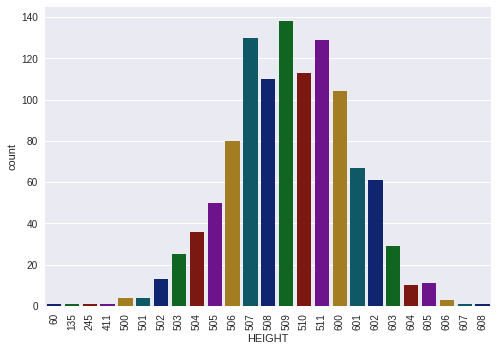

CPU times: user 564 ms, sys: 0 ns, total: 564 ms
Wall time: 1.06 s


In [28]:
%%time

seaborn.countplot(x='HEIGHT', data=sexoff, palette="dark")

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

seaborn.plt.show()


## Show amount of minor victims

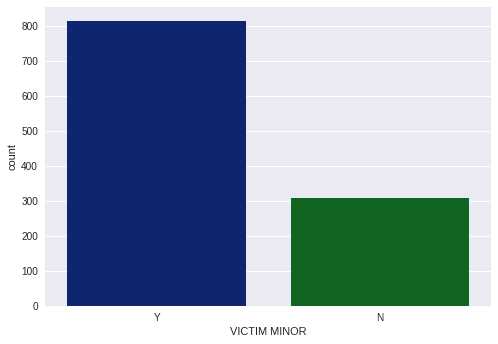

CPU times: user 300 ms, sys: 0 ns, total: 300 ms
Wall time: 545 ms


In [29]:
%%time

seaborn.countplot(x='VICTIM MINOR', data=sexoff, palette="dark")
seaborn.plt.show()


## Show amount of minor and no minor victims by targeted by offender sex

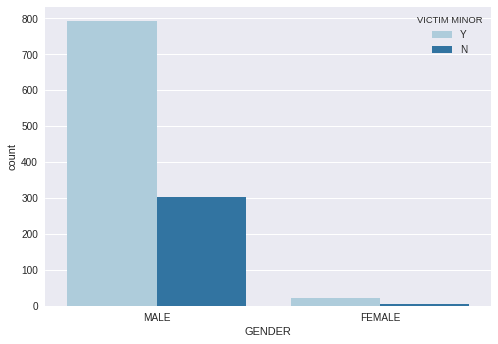

CPU times: user 356 ms, sys: 0 ns, total: 356 ms
Wall time: 593 ms


In [30]:
%%time

seaborn.countplot(x='GENDER', hue='VICTIM MINOR', data=sexoff, palette="Paired")
seaborn.plt.show()


# Gun offenders in chicago
## Read data

In [31]:
%%time

gunoff = pandas.read_csv("./datasets/Gun_Offenders.csv")


CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 151 ms


## Print first 10 rows

In [32]:
%time gunoff


CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.89 ms


,caseNumber,created_date,modified_date,lastName,firstName,middleName,Date_Of_Birth,sex,race,full_address,city,state,zip_code,district,post,neighborhood,Longitude,Latitude,Location 1
0,17-0301,08/21/2017 12:00:00 AM,08/21/2017,Gyant,Deandre,NaN,06/01/1991,Male,Black,Homeless,Homeless,MD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17-0300,08/21/2017 12:00:00 AM,08/21/2017,Brandon,Jarad,NaN,09/22/1987,Male,Black,2 S GILMOR ST Apt 2,Baltimore,MD,21223,SD,933.0,Union Square,-76.642412,39.288244,"(39.2882443122439, -76.6424122472685)"
2,17-0299,08/18/2017 12:00:00 AM,08/18/2017,Forney,Justin,NaN,12/13/1991,Male,Black,5100 CHALGROVE AV,Baltimore,MD,21215,NWD,614.0,Central Park Heights,-76.671197,39.350362,"(39.3503620513041, -76.6711973043507)"
3,17-0298,08/15/2017 12:00:00 AM,08/18/2017,White,Lanier,NaN,04/13/1992,Male,Black,8033 EastDale Rd,Dundalk,MD,21224,Out of Jurisdiction,NaN,NaN,NaN,NaN,NaN
4,17-0297,08/14/2017 12:00:00 AM,08/16/2017,Harris,Trenton,NaN,08/06/1991,Male,Black,4615 ASBURY AV,Baltimore,MD,21206,NED,443.0,Frankford,-76.560364,39.330869,"(39.3308689928877, -76.5603640282752)"
5,17-0296,08/11/2017 12:00:00 AM,08/11/2017,Davis,Ricardo,NaN,09/05/1979,Male,Black,21 Bonbon Ct,Reisterstown,MD,21236,Out of Jurisdiction,NaN,NaN,NaN,NaN,NaN
6,17-0295,08/08/2017 12:00:00 AM,08/08/2017,Morten,Harrison,NaN,11/17/1992,Male,Black,6838 STURBRIDGE DR Apt A,Baltimore,MD,21234,NED,423.0,Hamilton Hills,-76.563046,39.368921,"(39.3689207814868, -76.5630464640503)"
7,17-0294,08/08/2017 12:00:00 AM,08/08/2017,Reeder,Renard,NaN,03/03/1995,Male,Black,5019 ARBUTUS AV,Baltimore,MD,21215,NWD,613.0,Langston Hughes,-76.680500,39.342546,"(39.3425459213419, -76.6805001216217)"
8,17-0293,08/02/2017 12:00:00 AM,08/02/2017,Morris,Leonard,NaN,10/02/1986,Male,Black,1535 W FAIRMOUNT AV,Baltimore,MD,21223,WD,711.0,Franklin Square,-76.641556,39.288952,"(39.2889518905777, -76.6415560927958)"
9,17-0292,07/12/2017 12:00:00 AM,07/19/2017,Radcliffe,Theodore,NaN,11/09/1985,Male,Black,7 WHEELER AV,Baltimore,MD,21223,WD,714.0,Penrose/Fayette Street Outreach,-76.654333,39.288331,"(39.2883312342885, -76.6543325967314)"


## Check if our columns contains null data

In [33]:
%time gunoff.isnull().any()


CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 21.4 ms


caseNumber       False
created_date     False
modified_date    False
lastName         False
firstName        False
middleName        True
Date_Of_Birth    False
sex              False
race             False
full_address      True
city              True
state             True
zip_code          True
district          True
post              True
neighborhood      True
Longitude         True
Latitude          True
Location 1        True
dtype: bool

## Check which types our columns contains

In [34]:
%time gunoff.dtypes


CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 419 µs


caseNumber        object
created_date      object
modified_date     object
lastName          object
firstName         object
middleName        object
Date_Of_Birth     object
sex               object
race              object
full_address      object
city              object
state             object
zip_code          object
district          object
post             float64
neighborhood      object
Longitude        float64
Latitude         float64
Location 1        object
dtype: object

## Show amount of gun offenders by race

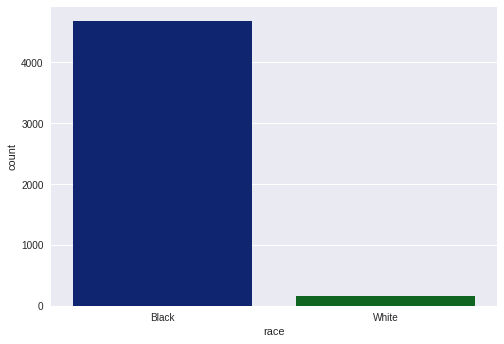

CPU times: user 292 ms, sys: 0 ns, total: 292 ms
Wall time: 636 ms


In [35]:
%%time

seaborn.countplot(x='race', data=gunoff, palette="dark")
seaborn.plt.show()


## Show amount of gun offenders by Sex

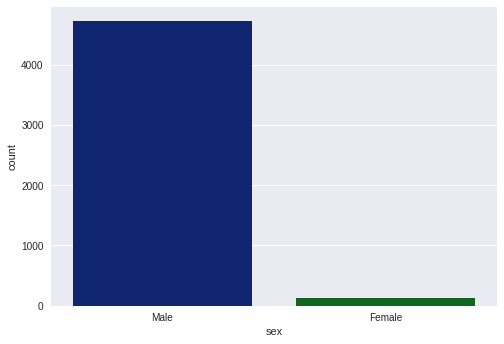

CPU times: user 272 ms, sys: 0 ns, total: 272 ms
Wall time: 588 ms


In [36]:
%%time

seaborn.countplot(x='sex', data=gunoff, palette="dark")
seaborn.plt.show()


## Show ammount of gun offenders per state

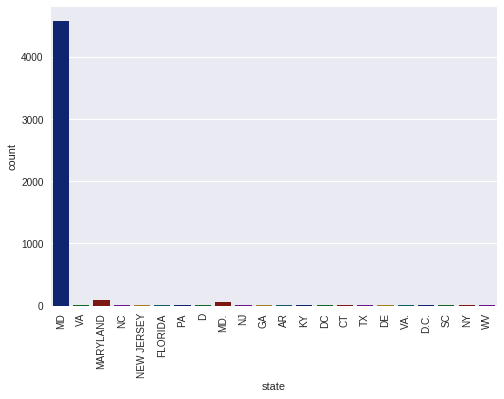

CPU times: user 464 ms, sys: 8 ms, total: 472 ms
Wall time: 678 ms


In [37]:
%%time

seaborn.countplot(x='state', data=gunoff, palette="dark")

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

seaborn.plt.show()


# Map US met hopelijk usefull data.



In [38]:
%%time
 

state_geo = './datatsets/state.geo.json'



#Let Folium determine the scale
map = folium.Map(location=[48, -102], zoom_start=3)
map.geo_json(geo_path=state_geo, data=homicide,
             columns=['State'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Murders(%)')
map

AttributeError: 'Map' object has no attribute 'geo_json'

In [ ]:
len(homicide.index)
homicide
#homicide[homicide['State'] != None].head()
#homicide[homicide['Perpetrator Age'] == ' '].head()
#homicide[homicide['State'] != 'Alaska'].head()
